In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-2024-11-20',
    api_version='2024-08-01-preview',   
)

small_llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-mini-2024-07-18',
    api_version='2024-08-01-preview',
)

In [3]:
small_llm.invoke('test')

AIMessage(content='Test successful! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected'

In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [6]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()


In [7]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x12a6151c0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x12a6151c0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x12a6151c0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x12a6151c0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x12a6151c0>)]

In [8]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [9]:
import os

from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = AzureOpenAIEmbeddings(
    model='text-embedding-3-large',
    azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDING_ENDPOINT'),
    api_key=os.getenv('AZURE_OPENAI_EMBEDDING_API_KEY')
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

In [10]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [11]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [12]:
def agent(state: AgentState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [13]:
def summarize_messages(state: AgentState):
    messages = state['messages']
    summary = state['summary']
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    summary = small_llm.invoke(summary_prompt)
    response = llm_with_tools.invoke(messages)
    return {'summary': response.content}

In [14]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState):
    messages = state['messages']
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {'messages': delete_messages}

In [15]:
def should_continue(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    
    return 'summarize_messages'

In [16]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [17]:
from langgraph.graph import START, END


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

In [18]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph= graph_builder.compile(checkpointer=checkpointer)

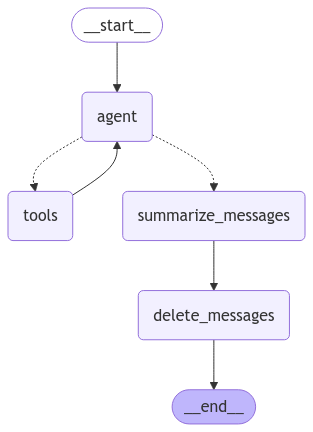

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

query = 'jasonkang14@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

jasonkang14@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_aKPkydAbRABUeL4s15YTksEU)
 Call ID: call_aKPkydAbRABUeL4s15YTksEU
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 mo

In [26]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cyvuoFvr7mjLOhyW0DOS7k6e', 'function': {'arguments': '{"message":"안녕하세요,\\n\\n\\"Attention Is All You Need\\" 논문에 대한 간단한 요약을 아래에 첨부합니다:\\n\\n이 논문은 Transformer 모델의 주목 메커니즘과 그것이 자연어 처리(NLP) 작업에서 어떻게 활용되는지를 다루고 있습니다. 특히, 입력 시퀀스의 모든 단어가 다른 모든 단어에 주의를 기울일 수 있는 능력을 강조합니다. 이 메커니즘은 모델이 더 효과적으로 문맥을 이해하고 더 나은 결과를 생성할 수 있도록 도와줍니다.\\n\\nTransformer는 인코더-디코더 구조를 가지고 있으며, 병렬 처리의 이점을 활용하여 학습 시간과 성능을 개선합니다. 이 모델은 번역, 텍스트 생성 등 다양한 NLP 작업에서 뛰어난 성능을 보여주고 있습니다.\\n\\n더 궁금한 점이 있으면 언제든지 말씀해 주세요.\\n\\n감사합니다.","to":["jasonkang14@gmail.com"],"subject":"Attention Is All You Need 논문 요약"}', 'name': 'create_gmail_draft'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 243, 'prompt_tokens': 1571, 'total_tokens': 1814, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 

In [29]:
graph.get_state(config).values['summary']


'이메일 초안이 성공적으로 작성되었습니다. 내용은 "Attention Is All You Need" 논문에 대한 요약을 포함하고 있습니다. 필요하신 경우 수정 후 발송하실 수 있습니다.'

In [22]:
# from langchain_core.messages import RemoveMessage

# for index, message in enumerate(current_message_list):
#     if index < len(current_message_list) - 1:
#         graph.update_state(config, {'messages': RemoveMessage(id=message.id)})

In [23]:
# current_message_list = graph.get_state(config).values['messages']
# current_message_list

In [30]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

update_query = '논문의 출처 URL을 포함시켜주세요'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

논문의 출처 URL을 포함시켜주세요
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_qhxfodmUPn68JuMdqNem0GUe)
 Call ID: call_qhxfodmUPn68JuMdqNem0GUe
  Args:
    query: Attention Is All You Need paper URL


/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================= Tool Message =================================
Name: duckduckgo_search

We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality wh

In [31]:
graph.get_state(config).values['summary']


'이메일 초안이 성공적으로 작성되었습니다. 내용은 "Attention Is All You Need" 논문에 대한 요약과 함께 논문 링크가 포함되어 있습니다. 필요에 따라 수정 후 발송하실 수 있습니다.'

In [25]:
# send_query = '이메일을 전송해주세요'
# for chunk in graph.stream({'messages': [HumanMessage(send_query)]}, config=config, stream_mode='values'):
#     chunk['messages'][-1].pretty_print()